In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score

plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read input files

In [3]:
# Decided to use both input dataset 1 and 2 to get more data to train on
#df = pd.read_parquet("../container-data/input_dataset-1.parquet")
df = pd.read_parquet("../container-data/input_dataset-2.parquet")
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")

In [4]:
pred_cols = ["Bolt_"+str(x)+"_Tensile" for x in range(1,7)]+list(pred_df.columns)
pred_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [5]:
#df = pd.concat([df1.loc[:,pred_cols], df2.loc[:,pred_cols]], axis=0)

In [6]:
#df.to_pickle("../container-data/df.pkl")

In [7]:
#df = pd.read_pickle("../container-data/df.pkl")
df = df.loc[:,pred_cols]

In [8]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode'],
      dtype='object')

# Common preprocessing

In [9]:
# Want to extract the time of the earliest datapoint in the dataset
start_time = df.index.min()
start_time

Timestamp('1970-12-19 09:51:44')

In [10]:
df.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,,,,,,,
1970-12-19 09:51:44,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation
1970-12-19 09:51:45,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation
1970-12-19 09:51:46,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation
1970-12-19 09:51:47,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation
1970-12-19 09:51:48,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation


In [11]:
def common_prep(df):
    df["datetime"] = df.index.values
    df.index = np.arange(len(df))
    # We drop rows with missing. No use in trying to impute. Creates more uncertainty.
    df = df.dropna()
    return df

In [12]:
df = common_prep(df)

Want to make a holdout dataset for validation. This is held separate from crossvalidation.

The holdout-set is chosen as 20% of the data. (Not chunked in time.)

Argue that we do not get data leakage from the future, but get better validation that we are able to model dependencies across the whole dataset. 

In [13]:
def split_trn_val(df, frac=0.2):
    df = df.copy()
    val_inds = np.random.choice(df.index.values, size=int(len(df)*frac), replace=False)
    val_df = df.iloc[df.index.isin(val_inds)]
    trn_df = df.iloc[~df.index.isin(val_inds)]
    return trn_df, val_df

In [14]:
trn_df, val_df = split_trn_val(df)

In [15]:
len(trn_df), len(val_df)

(1400000, 350000)

In [16]:
val_df_dt = val_df["datetime"]

In [17]:
#trn_df.to_pickle("../container-data/trn_df.pkl")

In [18]:
#val_df.to_pickle("../container-data/val_df.pkl")

In [19]:
y_cols = ["Bolt_"+str(count)+"_Tensile" for count in range(1,7)]
y_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile']

In [20]:
def add_diff_cols(df):
    return df

In [21]:
def diff_bolt_pretension(df):
    pret = pd.read_csv("../container-data/bolt_pretension.csv", header=None)
    pret_dict = pd.Series(pret.iloc[:,1].values, index=pret.iloc[:,0]).to_dict()
    for y in y_cols:
        df[y] = df[y]-pret_dict[y.strip("_Tensile").replace("_", " ")]
    return df

def binarize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: 1 if x=="start" else 0)
    return df

def categorize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: "start" if x==1 else "operation")
    return df

def add_mode_switch(df):
    df["mode_switch"] = df["mode"]-(df["mode"].shift(fill_value=False))
    return df

def add_sec_since_switch(df):
    df["sec_since_switch"] = (df.groupby('mode')['datetime'].transform(lambda x: (x-x.min()).dt.seconds))
    return df

def add_days_since_start(df):
    df["days_since_start"] = (df["datetime"]-start_time).dt.days
    return df

def add_rolling_sum_speed(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_sum"+str(period)] = df["Turbine_Rotational Speed"].rolling(period, min_periods=1).sum()
    return df

def remove_cols(df):
    remove_cols = ["datetime"]
    df = df.drop(remove_cols, axis=1)
    return df

def preprocessing(df):
    # Those that are commented out was left out as no improvement in cv score was shown
    #df = diff_bolt_pretension(df)
    df = binarize_mode(df)
    df = add_mode_switch(df)
    df = add_sec_since_switch(df)
    df = add_days_since_start(df)
    #df = add_rolling_sum_speed(df)
    df = remove_cols(df)
    df = categorize_mode(df)
    return df

def split_x_y(df):
    X = df.drop(y_cols, axis=1)
    y = df.loc[:, y_cols]
    return X, y

In [22]:
trn_df = preprocessing(trn_df)
df_X_train, df_y_train = split_x_y(trn_df)

In [23]:
val_df = preprocessing(val_df)
df_X_val, df_y_val = split_x_y(val_df)

In [24]:
x_cols = set([x for x in df_X_train.columns])-set(y_cols)
x_cols

{'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'days_since_start',
 'mode',
 'mode_switch',
 'sec_since_switch'}

# Make column selectors

In [25]:
X = df_X_train
y = df_y_train

In [26]:
from sklearn.compose import make_column_selector

In [27]:
df.dtypes

Bolt_1_Tensile                           float64
Bolt_2_Tensile                           float64
Bolt_3_Tensile                           float64
Bolt_4_Tensile                           float64
Bolt_5_Tensile                           float64
Bolt_6_Tensile                           float64
Unit_4_Power                             float64
Unit_4_Reactive Power                    float64
Turbine_Guide Vane Opening               float64
Turbine_Pressure Drafttube               float64
Turbine_Pressure Spiral Casing           float64
Turbine_Rotational Speed                 float64
mode                                      object
datetime                          datetime64[ns]
dtype: object

In [28]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X), num_selector(X)

(['mode', 'mode_switch'],
 ['Unit_4_Power',
  'Unit_4_Reactive Power',
  'Turbine_Guide Vane Opening',
  'Turbine_Pressure Drafttube',
  'Turbine_Pressure Spiral Casing',
  'Turbine_Rotational Speed',
  'sec_since_switch',
  'days_since_start'])

# Make column transformers

## Tree preprocessor

In [29]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFE3D90>)])

## Linear preprocessor

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFE3D90>)])

# Make pipelines

## Lasso pipeline

In [76]:
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, MultiTaskLassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
lasso_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFE3D90>)])),
                ('lassocv',
                 LassoCV(cv=3, n_jobs=4, selection='random', verbose=Tru

## Random forest pipeline

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFE3D90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=3, n_jobs=6,
                                       random_state=42))])

# Stacking regressor  

In [33]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Lasso", lasso_pipeline),
    ("Random Forest", rf_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(cv=KFold(n_splits=3, shuffle=False), scoring="neg_mean_absolute_percentage_error"))
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline',
                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                                                                ('onehotencoder',
                                             

# Train models and make predictions on the validation set

In [55]:
scores = {}
preds = {}
residuals = {}
models = {}
for y in y_cols:
    scores[y] = {}
    preds[y] = {}
    residuals[y] = {}
    models[y] = {}
    print(y)
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y_train.drop(drop_cols, axis=1).values.flatten()
    y_val = df_y_val.drop(drop_cols, axis=1).values.flatten()
    lasso = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
    lasso.fit(df_X_train, y_train)
    y_pred = lasso.predict(df_X_val)
    lasso_res = lasso.predict(df_X_train)-y_train
    # Add residuals from lasso as y for RF
    rf = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
    rf.fit(df_X_train, lasso_res)
    rf_preds = rf.predict(df_X_val)
    
    score = mean_absolute_percentage_error(y_val, y_pred)
    scores[y]["lasso"] = score
    scores[y]["rf"] = mean_absolute_percentage_error(y_val, y_pred-rf_preds)
    print(scores[y])
    preds[y]["lasso"] = y_pred
    preds[y]["rf"] = rf_preds
    residuals[y]["lasso"] = y_val-y_pred
    residuals[y]["rf"] = y_val-(y_pred-rf_preds)
    models[y]["lasso"] = lasso
    models[y]["rf"] = rf

Bolt_1_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.8s finished


{'lasso': 0.0004134123743142366, 'rf': 1.1345919014299588e-05}
Bolt_2_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.1s finished


{'lasso': 0.0004749428862277227, 'rf': 9.719640069102622e-06}
Bolt_3_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.2s finished


{'lasso': 0.0003484749817558612, 'rf': 6.274113548499016e-06}
Bolt_4_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
..............................................................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.0562923530815, tolerance: 391.7031812172726
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 625.6812374633737, tolerance: 391.7031812172726
  model = cd_fast.enet_coordinate_descent_gram(
...........................................................................................[Paralle

{'lasso': 0.0004939398215329051, 'rf': 7.200637914455542e-06}
Bolt_5_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
...........................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 901.4108149575768, tolerance: 338.2293960658948
  model = cd_fast.enet_coordinate_descent_gram(
....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.6517301017884, tolerance: 338.2293960658948
  model = cd_fast.enet_coordinate_descent_gram(
............................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coor

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.4s finished


{'lasso': 0.0004985753603025273, 'rf': 8.549631230705661e-06}
Bolt_6_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
.........................................................................................................................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2992.9137703836896, tolerance: 2078.319551226579
  model = cd_fast.enet_coordinate_descent_gram(
...................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.3s finished


{'lasso': 0.00042338728038227724, 'rf': 1.458807671838709e-05}


# Investigate results

In [74]:
alphas = {}
for y in y_cols:
    m = models[y]["lasso"].steps[-1][1]
    a = m.alpha_
    alphas[y] = a
    coefs = m.coef_
    intercept = m.intercept_
    print(a)
    print(coefs)
    print(intercept)

0.010270134386885949
[ 3.25753264  0.         -0.          1.90522842  0.          1.39093107
  0.27899788 10.33517519 -0.          0.          0.          0.
 -0.        ]
1613.2845336660546
0.12201564420079512
[ 0.42616318  0.          0.79978741 -0.          0.          1.10795329
  0.          6.11083117  0.         -0.         -0.          0.
 -0.        ]
1490.368888270568
0.09028455752579792
[ 0.65008166  0.05760286  0.18320138 -0.         -0.          0.23125722
  0.          4.51162976  0.         -0.         -0.          0.
 -0.        ]
1690.2583936464323
0.3483779595324308
[ 0.          0.          1.15856219 -0.         -0.          0.54410014
  0.          0.59209826  0.         -0.         -0.          0.
 -0.        ]
1602.8972956468244
0.3380721249501204
[ 0.          0.          0.91121637 -0.         -0.          0.48895261
 -0.          0.38517213  0.         -0.         -0.          0.
 -0.        ]
1637.4215835412895
0.003717891384923309
[ 3.65466773  0.10554657 -

In [57]:
scores

{'Bolt_1_Tensile': {'lasso': 0.0004134123743142366,
  'rf': 1.1345919014299588e-05},
 'Bolt_2_Tensile': {'lasso': 0.0004749428862277227,
  'rf': 9.719640069102622e-06},
 'Bolt_3_Tensile': {'lasso': 0.0003484749817558612,
  'rf': 6.274113548499016e-06},
 'Bolt_4_Tensile': {'lasso': 0.0004939398215329051,
  'rf': 7.200637914455542e-06},
 'Bolt_5_Tensile': {'lasso': 0.0004985753603025273,
  'rf': 8.549631230705661e-06},
 'Bolt_6_Tensile': {'lasso': 0.00042338728038227724,
  'rf': 1.458807671838709e-05}}

<AxesSubplot:>

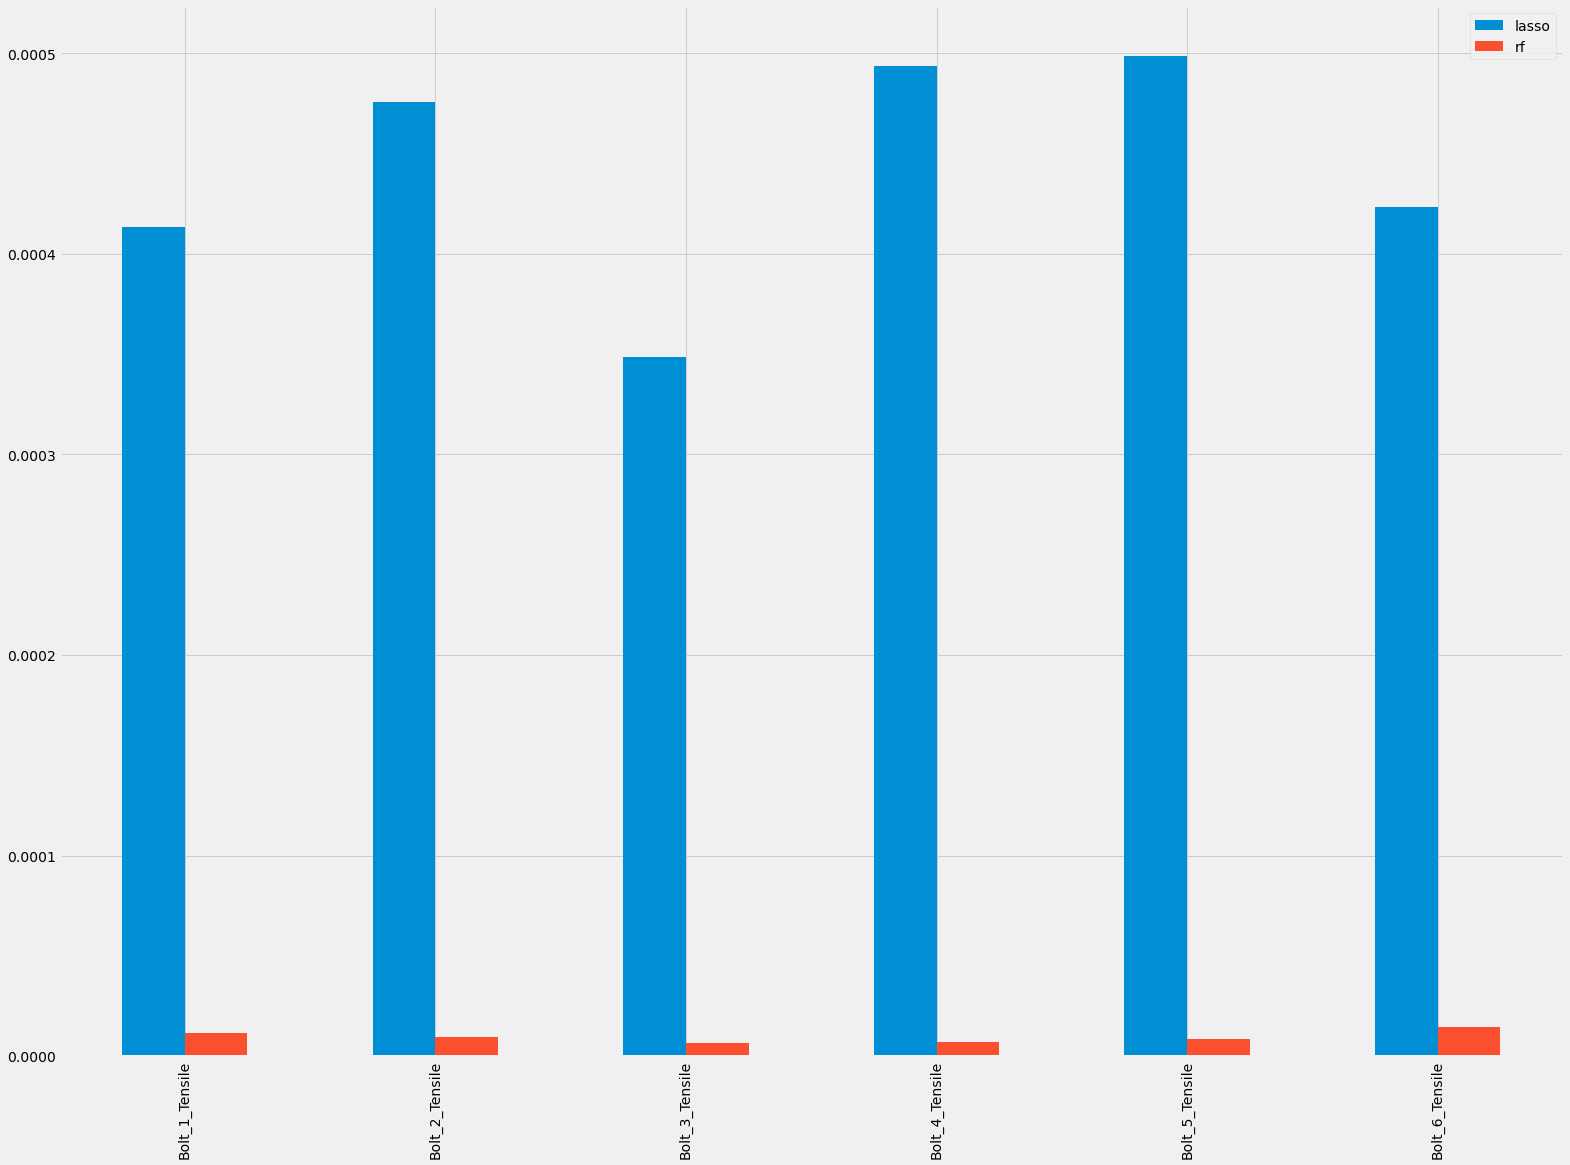

In [47]:
score_df = pd.DataFrame.from_dict(scores, orient="index")
score_df.plot(kind="bar", figsize=(24,18))

In [48]:
score_df.mean()

lasso    0.000442
rf       0.000010
dtype: float64

# Plot feature importances

## Which features are important to model the errors from the linear model?

In [43]:
models

{'Bolt_1_Tensile': {'lasso': Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('pipeline',
                                                    Pipeline(steps=[('standardscaler',
                                                                     StandardScaler()),
                                                                    ('simpleimputer',
                                                                     SimpleImputer(add_indicator=True))]),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFA53D0>),
                                                   ('onehotencoder',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001A56CFE3D90>)])),
                  ('lassocv',
                   Lass

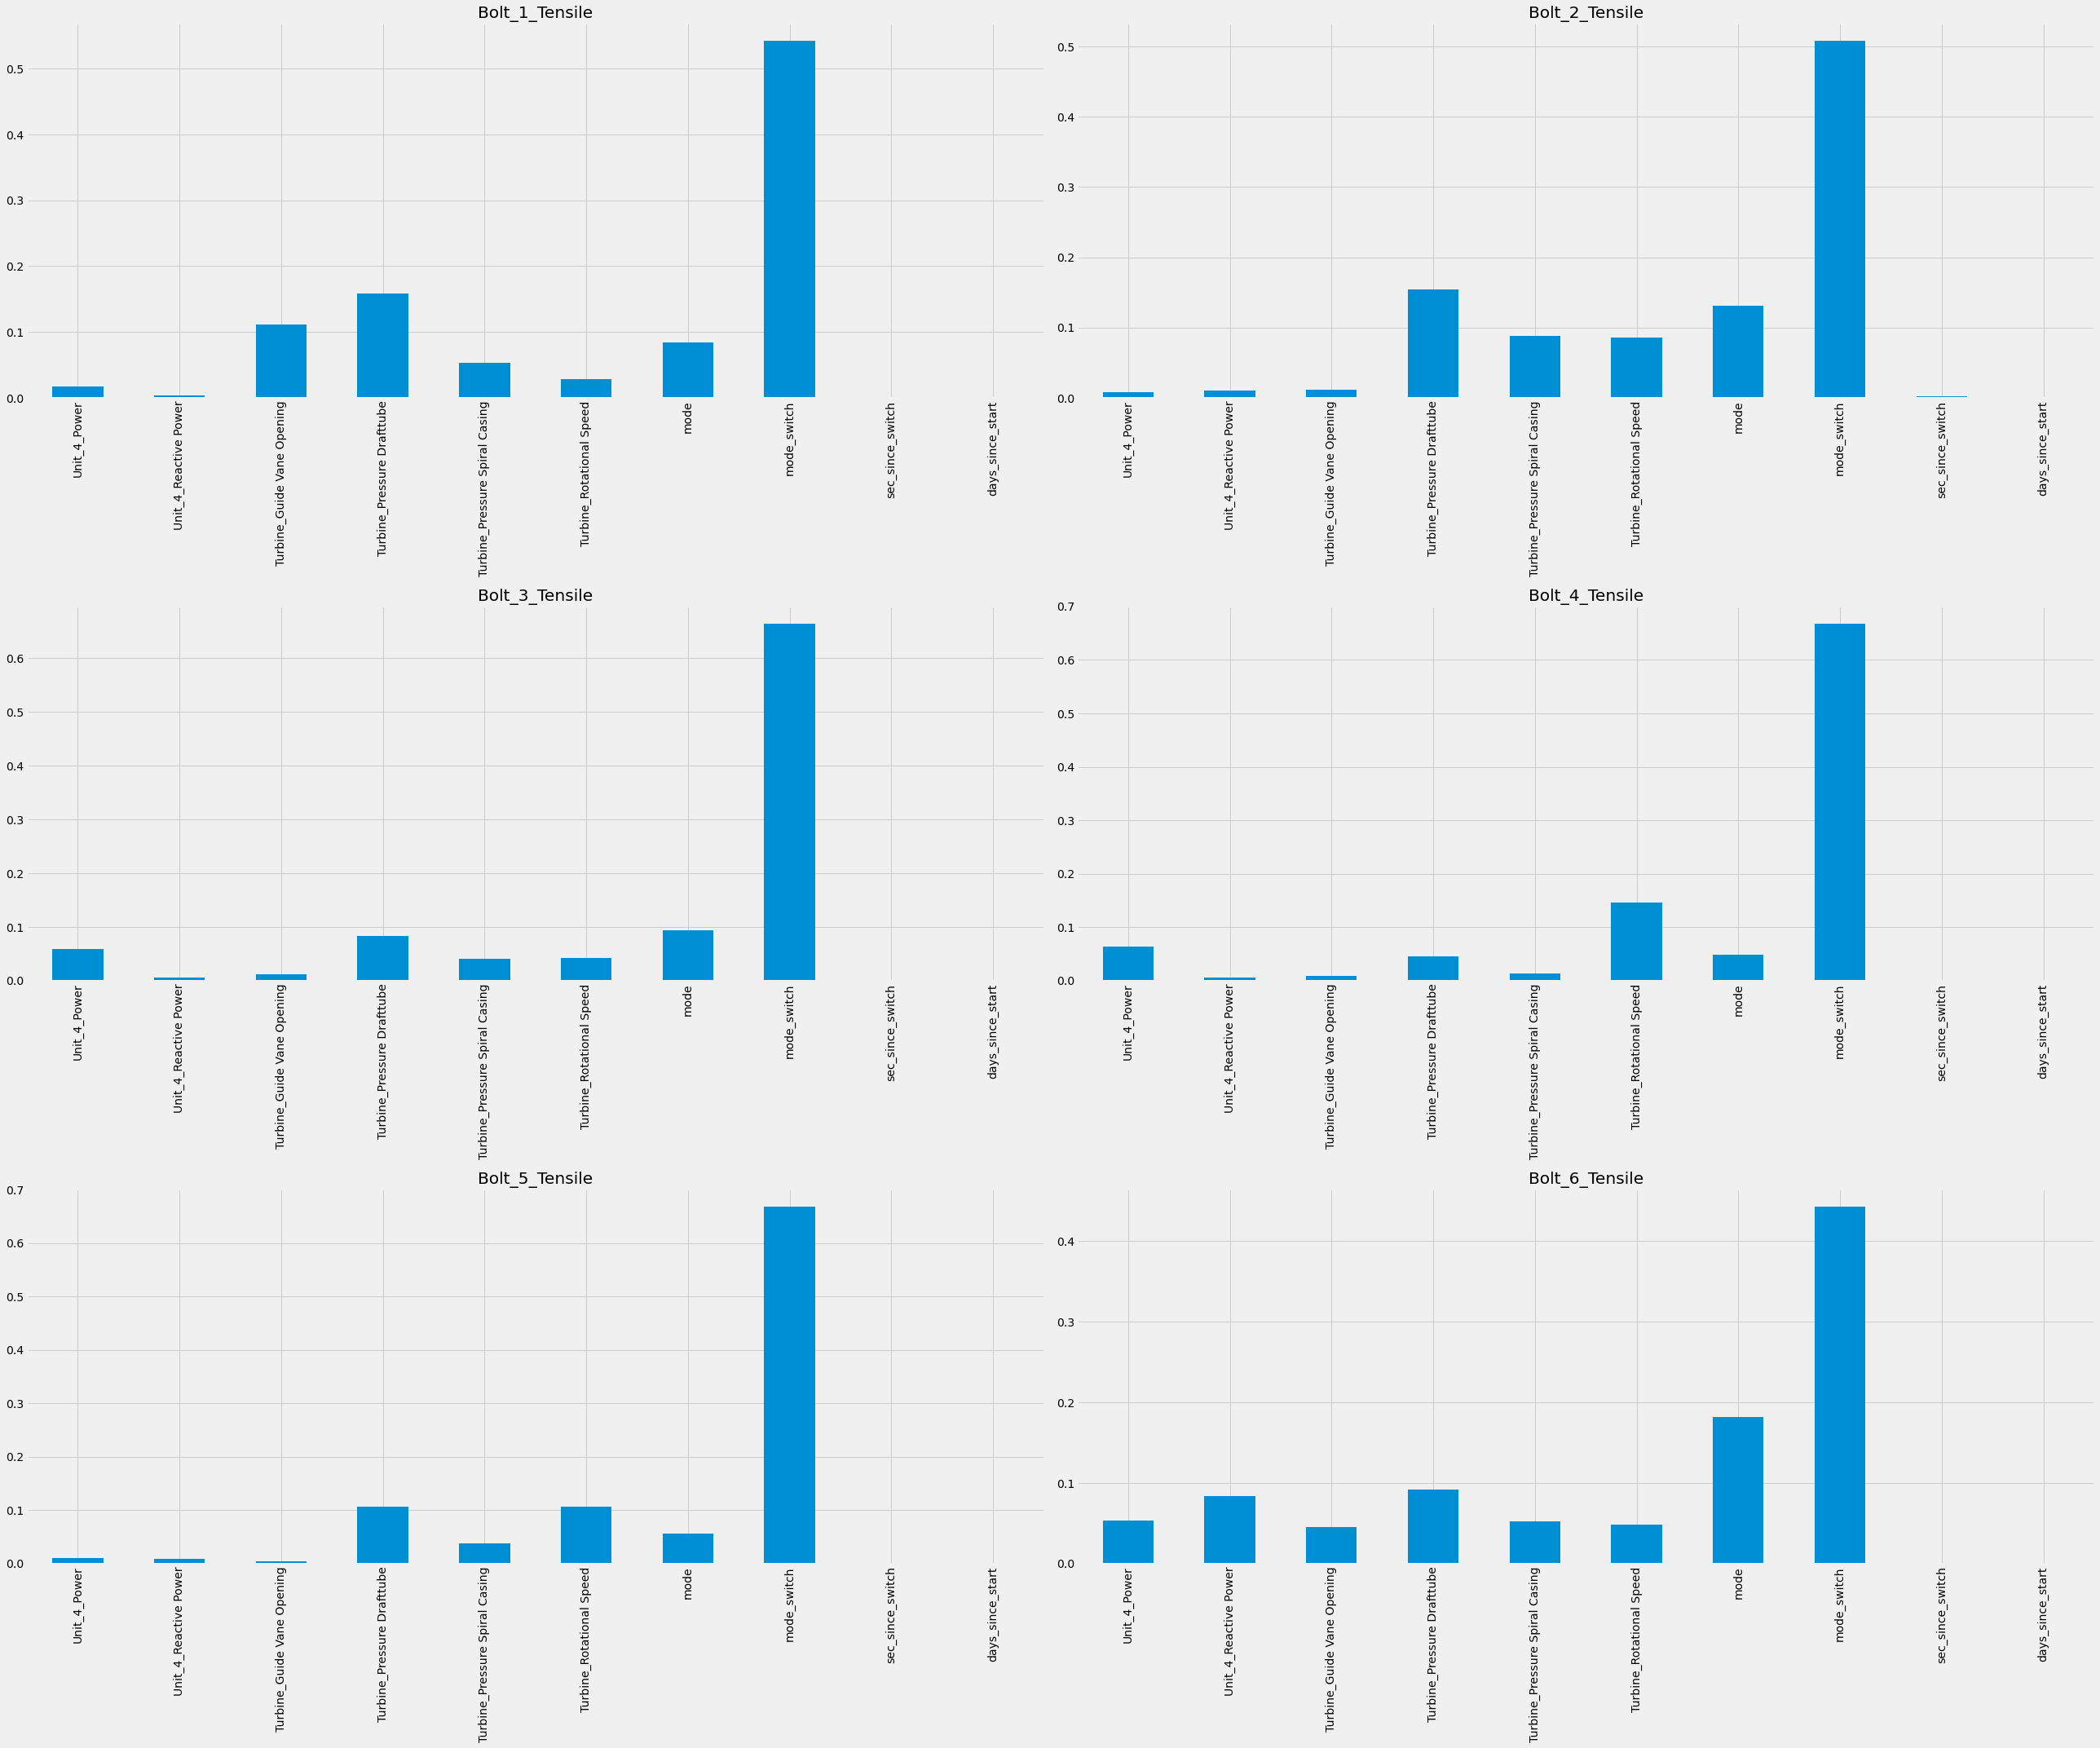

In [72]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(36,30))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        model = models[name]["rf"].steps[-1][1]
        imps = pd.Series(model.feature_importances_, index=df_X_val.columns)
        imps.plot(kind="bar", ax=axes[r,c], title=name)
        count+=1
plt.tight_layout()

Seems like mode_switch is something the random forest can make use of

# Plot residuals

Where do we miss?

In [58]:
res_df = pd.DataFrame(data=np.transpose([residuals[y]["lasso"] for y in y_cols]), index=val_df_dt, columns=y_cols)
res_df_rf = pd.DataFrame(data=np.transpose([residuals[y]["rf"] for y in y_cols]), index=val_df_dt, columns=y_cols)

In [59]:
res_df_rf

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
datetime,,,,,,
1970-12-19 09:51:45,-0.008207,-0.023926,-0.010698,-0.010805,0.000667,-0.033781
1970-12-19 09:51:46,-0.018359,-0.037716,-0.002975,-0.007814,-0.001755,-0.015286
1970-12-19 09:51:54,0.016923,0.064513,0.023900,0.002669,0.021928,0.005342
1970-12-19 09:51:55,0.004050,0.023032,0.022209,-0.009097,0.003938,0.004745
1970-12-19 09:51:56,-0.013276,0.012005,0.015335,-0.014142,-0.000544,0.008293
...,...,...,...,...,...,...
1971-01-25 11:06:28,-0.013537,-0.068234,-0.077064,0.005309,-0.001193,-0.029316
1971-01-25 11:06:34,0.017494,0.004779,-0.010267,-0.026469,-0.009119,-0.001636
1971-01-25 11:06:35,0.005226,0.016252,-0.001427,0.010001,0.004012,-0.007894


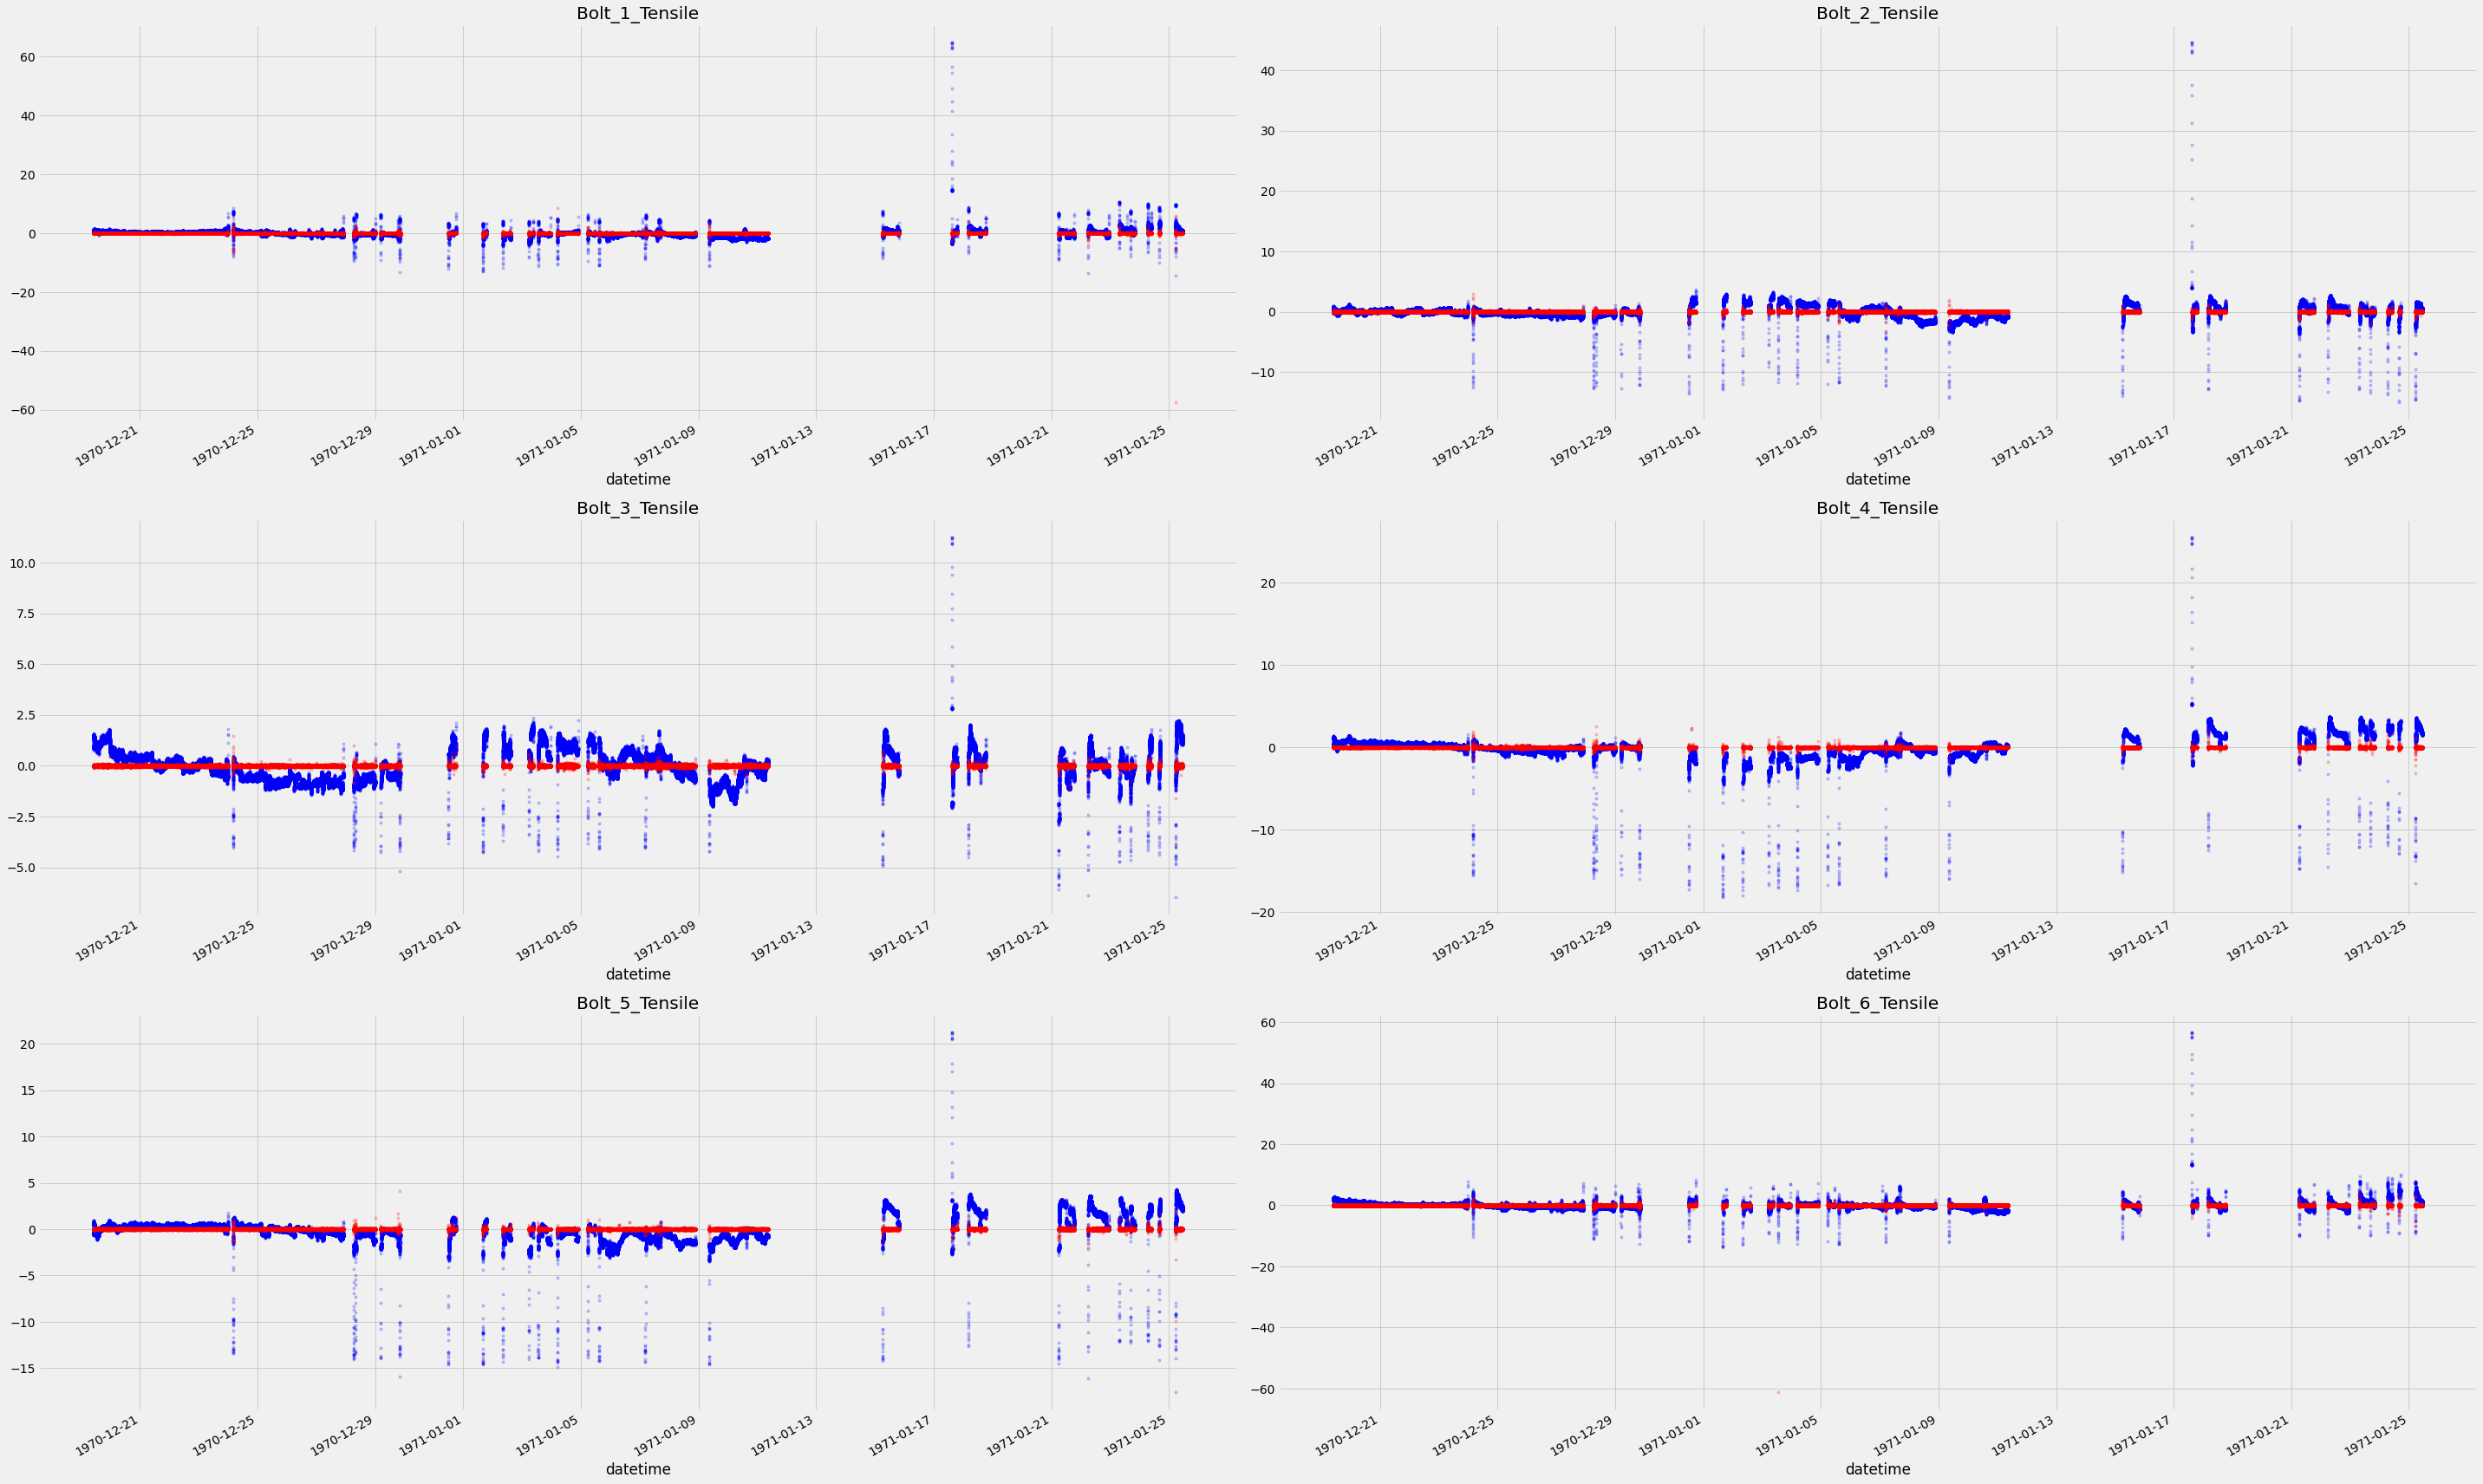

In [71]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        res_df[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, label="Lasso", color="b")
        res_df_rf[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, label="Random Forest", color="r")
        count+=1

plt.tight_layout()

# Train final model with whole dataset

In [61]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode', 'datetime'],
      dtype='object')

In [62]:
final_df = preprocessing(df)

In [63]:
df_X, df_y = split_x_y(final_df) 

In [64]:
df_X.columns, df_y.columns

(Index(['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
        'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
        'Turbine_Rotational Speed', 'mode', 'mode_switch', 'sec_since_switch',
        'days_since_start'],
       dtype='object'),
 Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
        'Bolt_5_Tensile', 'Bolt_6_Tensile'],
       dtype='object'))

In [86]:
fitted = {}
out_preds = {}
for y in y_cols:
    
    fitted[y] = {}
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y.drop(drop_cols, axis=1).values.flatten()
    lasso = make_pipeline(linear_preprocessor, Lasso(alpha=0.1, selection="random", max_iter=1000))
    lasso.fit(df_X, y_train)
    fitted[y]["lasso"] = lasso
    y_pred = lasso.predict(df_X)
    y_res = y_pred-y_train
    
    # Add residuals from lasso as y for RF
    rf = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
    rf.fit(df_X, y_res)
    fitted[y]["rf"] = rf
    rf_preds = rf.predict(df_X)
    
    out_preds[y] = (y_pred-rf_preds)

In [87]:
out_preds

{'Bolt_1_Tensile': array([1598.48143685, 1598.47844049, 1598.4793158 , ..., 1637.37064954,
        1637.35287197, 1637.34925434]),
 'Bolt_2_Tensile': array([1480.99529139, 1480.99455678, 1481.00318827, ..., 1504.53370156,
        1504.52918425, 1504.52746293]),
 'Bolt_3_Tensile': array([1684.2532545 , 1684.26375886, 1684.27050423, ..., 1701.65643362,
        1701.6599393 , 1701.66039238]),
 'Bolt_4_Tensile': array([1601.38028471, 1601.38412232, 1601.3742541 , ..., 1606.25776036,
        1606.25884429, 1606.27310681]),
 'Bolt_5_Tensile': array([1635.58518978, 1635.58692414, 1635.58346428, ..., 1640.70332092,
        1640.68984282, 1640.69433184]),
 'Bolt_6_Tensile': array([1674.90757537, 1674.82992653, 1674.84131793, ..., 1690.00721403,
        1689.99814349, 1690.00174985])}

In [88]:
y_pred, y_res, rf_preds

(array([1673.09063392, 1673.08993777, 1673.08924162, ..., 1688.58652994,
        1688.58712762, 1688.5877253 ]),
 array([-1.75816913, -1.73394498, -1.7520763 , ..., -1.41547793,
        -1.4080072 , -1.41703322]),
 array([-1.81694145, -1.73998876, -1.7520763 , ..., -1.42068409,
        -1.41101587, -1.41402455]))

# Apply same preprocessing to input prediction data

In [89]:
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")
pred_df_datetime = pred_df.index
pred_df = common_prep(pred_df)
pred_df = preprocessing(pred_df)

## Make predictions with final model for submission

In [94]:
for y_col, pipes in fitted.items():
    print(y_col)
    for name, pipeline in pipes.items():
        print(name)        
        pred_df[y_col+name] = pipeline.predict(pred_df.loc[:,df_X.columns])
    pred_df[y_col] = pred_df[y_col+"lasso"]-pred_df[y_col+"rf"] 

Bolt_1_Tensile
lasso
rf
Bolt_2_Tensile
lasso
rf
Bolt_3_Tensile
lasso
rf
Bolt_4_Tensile
lasso
rf
Bolt_5_Tensile
lasso
rf
Bolt_6_Tensile
lasso
rf


In [95]:
pred_df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start,...,Bolt_5_Tensilelasso,Bolt_5_Tensilerf,Bolt_6_Tensilelasso,Bolt_6_Tensilerf,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
0,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation,0,0,37,...,1639.315815,-1.632050,1688.573425,-1.705479,1637.519180,1504.669022,1701.744556,1606.293090,1640.947865,1690.278904
1,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation,0,1,37,...,1639.316243,-1.632050,1688.574023,-1.705479,1637.519831,1504.680980,1701.749129,1606.298434,1640.948294,1690.279502
2,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation,0,2,37,...,1639.316672,-1.575546,1688.574621,-1.705479,1637.521184,1504.681657,1701.739276,1606.298775,1640.892218,1690.280100
3,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation,0,3,37,...,1639.317100,-1.575546,1688.575218,-1.693332,1637.596612,1504.682333,1701.744652,1606.289292,1640.892646,1690.268550
4,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation,0,4,37,...,1639.317529,-1.575546,1688.575816,-1.693332,1637.612641,1504.711720,1701.750028,1606.273910,1640.893075,1690.269148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226359,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,operation,0,32970,46,...,1633.189707,-1.198350,1683.239137,-5.600922,1641.617127,1500.824419,1698.401249,1599.924016,1634.388057,1688.840059
226360,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,operation,0,32971,46,...,1633.068886,-1.198350,1683.084843,-5.559059,1641.474669,1500.694784,1698.309278,1599.783272,1634.267236,1688.643901
226361,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,operation,0,32972,46,...,1632.948058,-1.198350,1682.930541,-5.559059,1641.332208,1500.565148,1698.217302,1599.642519,1634.146408,1688.489600
226362,104.454741,-22.274208,42.121151,100.035287,5420.094237,106.711070,operation,0,32973,46,...,1632.827231,-1.198350,1682.776239,-5.559059,1641.189746,1500.435512,1698.125326,1599.501321,1634.025580,1688.335298


In [96]:
pred_df = pred_df.set_index(pred_df_datetime)
pred_df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start,...,Bolt_5_Tensilelasso,Bolt_5_Tensilerf,Bolt_6_Tensilelasso,Bolt_6_Tensilerf,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,,,,,,,,,,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation,0,0,37,...,1639.315815,-1.632050,1688.573425,-1.705479,1637.519180,1504.669022,1701.744556,1606.293090,1640.947865,1690.278904
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation,0,1,37,...,1639.316243,-1.632050,1688.574023,-1.705479,1637.519831,1504.680980,1701.749129,1606.298434,1640.948294,1690.279502
1971-01-25 11:06:51,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation,0,2,37,...,1639.316672,-1.575546,1688.574621,-1.705479,1637.521184,1504.681657,1701.739276,1606.298775,1640.892218,1690.280100
1971-01-25 11:06:52,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation,0,3,37,...,1639.317100,-1.575546,1688.575218,-1.693332,1637.596612,1504.682333,1701.744652,1606.289292,1640.892646,1690.268550
1971-01-25 11:06:53,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation,0,4,37,...,1639.317529,-1.575546,1688.575816,-1.693332,1637.612641,1504.711720,1701.750028,1606.273910,1640.893075,1690.269148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-02-03 20:16:19,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,operation,0,32970,46,...,1633.189707,-1.198350,1683.239137,-5.600922,1641.617127,1500.824419,1698.401249,1599.924016,1634.388057,1688.840059
1971-02-03 20:16:20,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,operation,0,32971,46,...,1633.068886,-1.198350,1683.084843,-5.559059,1641.474669,1500.694784,1698.309278,1599.783272,1634.267236,1688.643901
1971-02-03 20:16:21,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,operation,0,32972,46,...,1632.948058,-1.198350,1682.930541,-5.559059,1641.332208,1500.565148,1698.217302,1599.642519,1634.146408,1688.489600


In [97]:
out_df = pred_df.loc[:,y_cols]
out_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,
1971-01-25 11:06:49,1637.519180,1504.669022,1701.744556,1606.293090,1640.947865,1690.278904
1971-01-25 11:06:50,1637.519831,1504.680980,1701.749129,1606.298434,1640.948294,1690.279502
1971-01-25 11:06:51,1637.521184,1504.681657,1701.739276,1606.298775,1640.892218,1690.280100
1971-01-25 11:06:52,1637.596612,1504.682333,1701.744652,1606.289292,1640.892646,1690.268550
1971-01-25 11:06:53,1637.612641,1504.711720,1701.750028,1606.273910,1640.893075,1690.269148
...,...,...,...,...,...,...
1971-02-03 20:16:19,1641.617127,1500.824419,1698.401249,1599.924016,1634.388057,1688.840059
1971-02-03 20:16:20,1641.474669,1500.694784,1698.309278,1599.783272,1634.267236,1688.643901
1971-02-03 20:16:21,1641.332208,1500.565148,1698.217302,1599.642519,1634.146408,1688.489600


In [98]:
assert (pred_df_datetime == out_df.index).all()

In [101]:
out_df.to_csv("../container-data/prediction_output_rerf.csv")

In [108]:
df.tail(1000).set_index("datetime")

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start
datetime,,,,,,,,,,,,,,,,
1971-01-25 10:50:09,1637.616146,1504.839934,1701.890416,1606.465205,1641.054899,1690.445411,305.439713,6.745441,93.960100,159.055286,5283.781712,108.063790,0,0,3505,37
1971-01-25 10:50:10,1637.577416,1504.848879,1701.895159,1606.422919,1641.057892,1690.426631,305.434507,6.646212,93.961153,159.101633,5283.685602,108.063784,0,0,3506,37
1971-01-25 10:50:11,1637.595438,1504.863194,1701.896514,1606.413217,1641.051902,1690.433324,305.429301,6.546983,93.962206,159.147980,5283.589492,108.063778,0,0,3507,37
1971-01-25 10:50:12,1637.579180,1504.842151,1701.886719,1606.397920,1641.033789,1690.413580,305.424095,6.447754,93.963259,159.194326,5283.493382,108.063771,0,0,3508,37
1971-01-25 10:50:13,1637.593230,1504.834026,1701.901137,1606.426416,1641.060318,1690.432654,305.418889,6.348525,93.964312,159.230013,5283.409524,108.063765,0,0,3509,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,1637.386115,1504.557822,1701.651420,1606.276545,1640.704071,1690.014705,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,0,0,4500,37
1971-01-25 11:06:45,1637.365865,1504.546091,1701.654301,1606.271877,1640.711250,1690.017029,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,0,0,4501,37
1971-01-25 11:06:46,1637.384133,1504.538696,1701.656143,1606.250028,1640.699142,1690.002008,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,0,0,4502,37


In [105]:
df_y 

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
0,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803
1,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883
2,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318
3,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245
4,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300
...,...,...,...,...,...,...
1874082,1637.386115,1504.557822,1701.651420,1606.276545,1640.704071,1690.014705
1874083,1637.365865,1504.546091,1701.654301,1606.271877,1640.711250,1690.017029
1874084,1637.384133,1504.538696,1701.656143,1606.250028,1640.699142,1690.002008
1874085,1637.357141,1504.531582,1701.662201,1606.245665,1640.685782,1689.995135


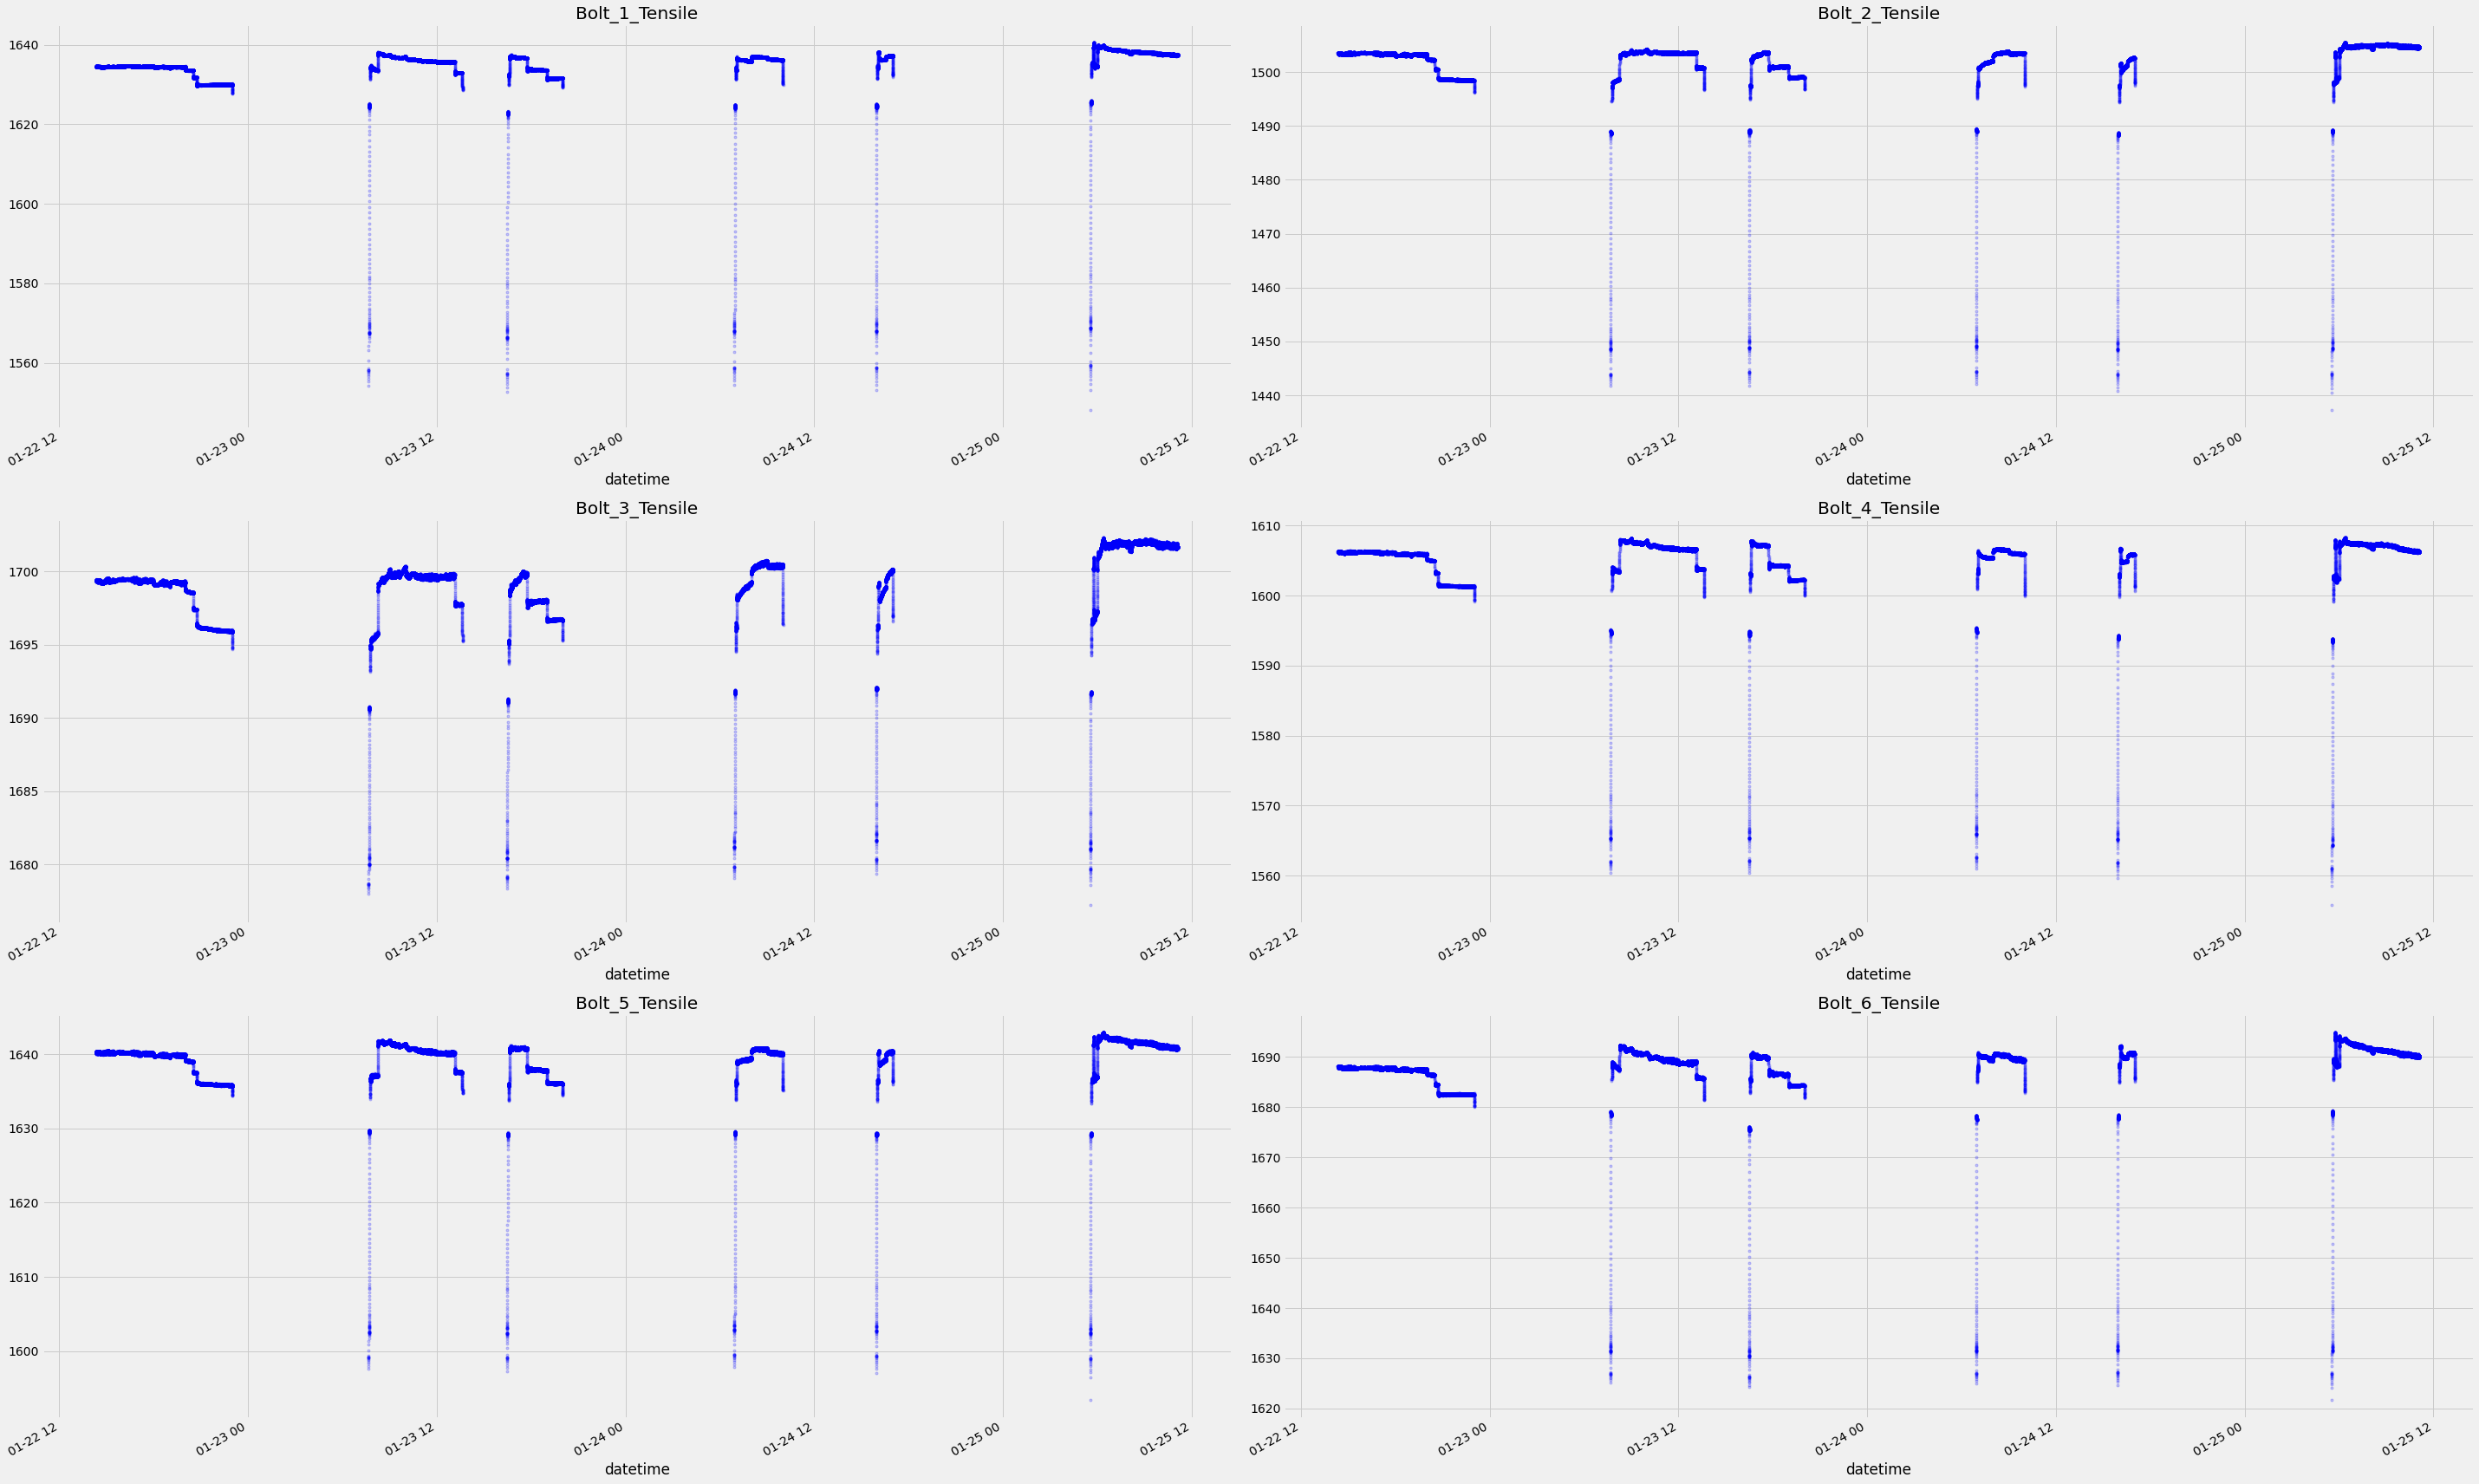

In [113]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        df.tail(100000).set_index("datetime").loc[:,name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, color="b")
        count+=1

plt.tight_layout()

## Verify that the predictions makes sense and see the impact of the two models

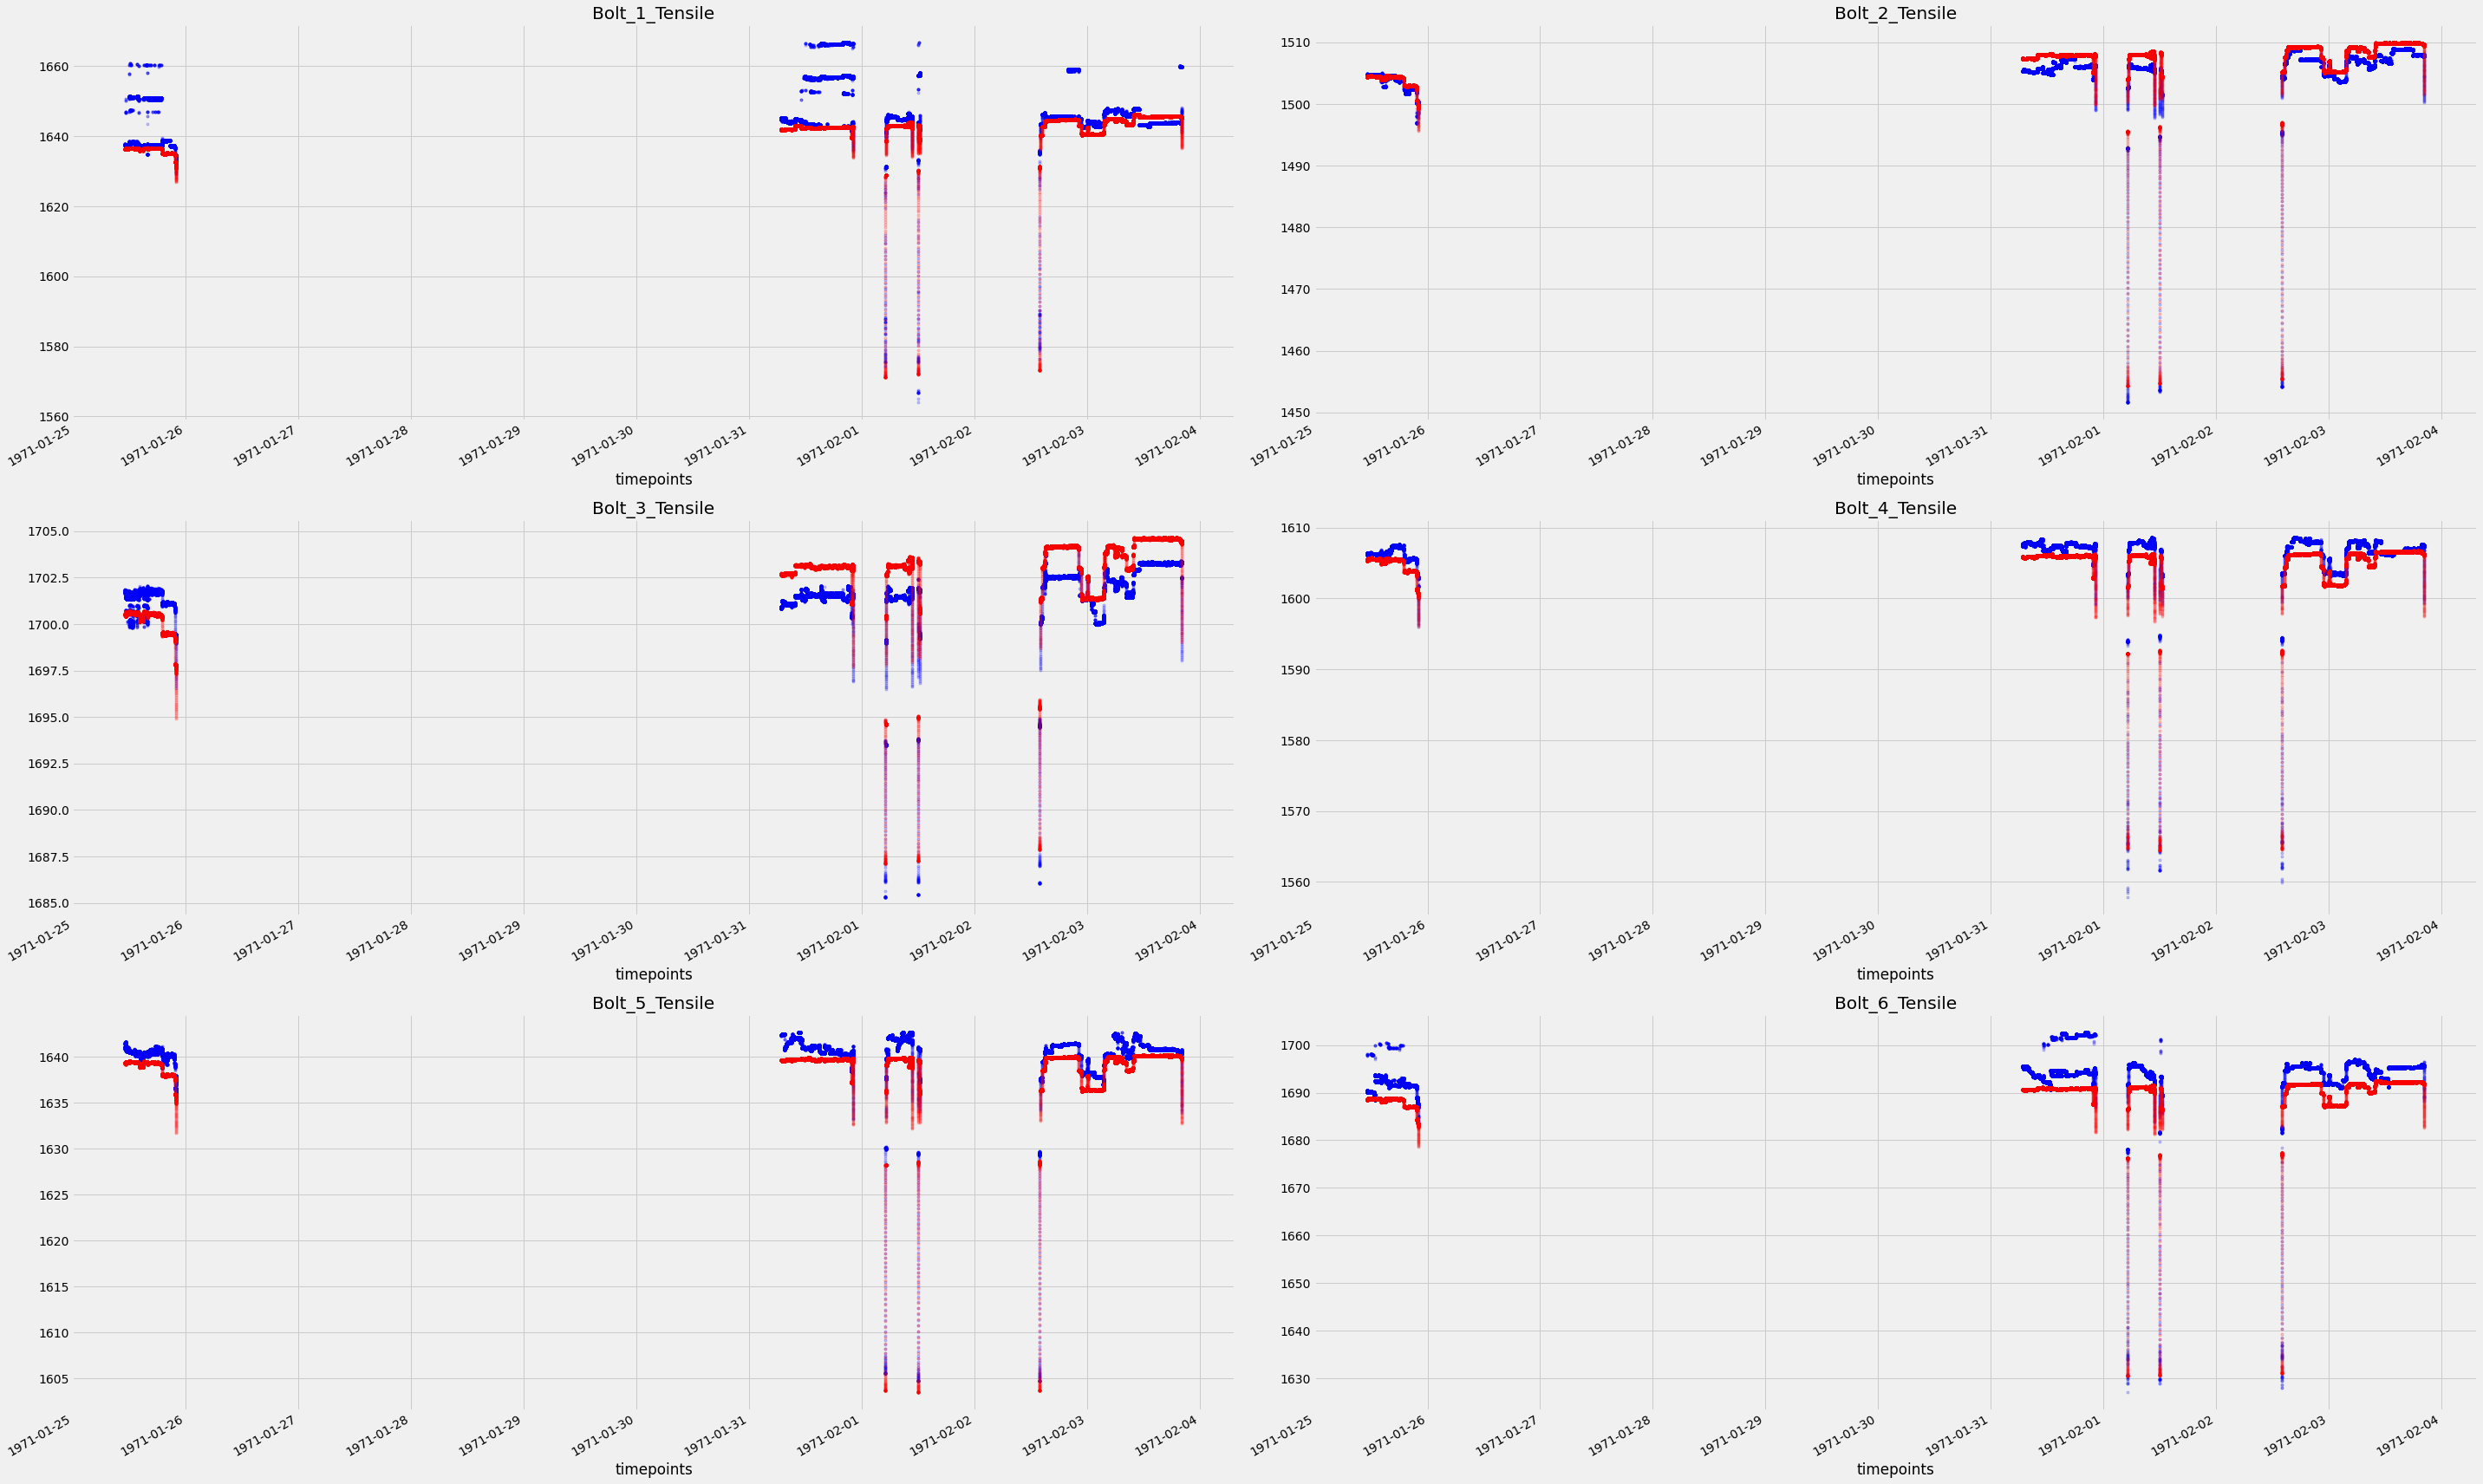

In [103]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        pred_df.loc[:,name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, color="b")
        pred_df.loc[:,name+"lasso"].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, color="r")
        count+=1

plt.tight_layout()